# Speech recognition model

Here we implement CNN for predicting voice commands in a given audio file. 

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from tensorboard.plugins.hparams import api as hp

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


Load the TensorBoard notebook extension.

In [2]:
%load_ext tensorboard


Clear any logs from previous runs


In [3]:
! rm -rf ./logs/

"rm" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


For speed purposes, we will only tune three hyperparameters: each hyperparameter will have two alternatives.
+ `HP_DROPOUT` = {0.1, 0.25}
+ `HP_NUM_UNITS` = {64, 128}
+ `HP_OPTIMIZER` = {adam, sgd}

In [4]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64, 128]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.25))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )


The code below is explained in `eda.ipynb`.

In [5]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')


In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

In [7]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [8]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2]

In [9]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [11]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [12]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [13]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)


## Dataset preprocessing

We convert all the audio files to its respective spectrograms and get its labels.

In [14]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [15]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)


A batch is a set of samples that will be used to improve the model in the training.

Its size is 64 because it's recommended to use a power of two.

In [16]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)


`cache()` and `prefetch` operations reduces read latency while training the model.

In [17]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

Here we define the input shape for the Neural Network and the Normalization layer.

In [18]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

Input shape: (124, 129, 1)


## Initial model
This is the model definied in the tutorial.

In [31]:
def get_initial_model():
    model = models.Sequential([
        layers.Input(shape=input_shape),
        preprocessing.Resizing(32, 32), 
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25), #dropout of units: avoids overfitting and generalizes more
        layers.Flatten(), #convert n-dimension input to 1-dimension output
        layers.Dense(128, activation='relu'),#Full-conected layer
        layers.Dropout(0.5),
        layers.Dense(num_labels),#output
    ])

    model.summary()
    return model

## Hyperparameter tuning
This function will be called when tuning hyperparameters.

The hyperparameters that will be tuned are:
+ `HP_DROPOUT` for the dropout layers.
+ `HP_NUM_UNITS` for the full-connected layer/dense.
+ `HP_OPTIMIZER` for the training optimizer.

In [20]:
def train_test_model_hparams(hparams):
    print(input_shape)
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        preprocessing.Resizing(32, 32), 
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(hparams[HP_DROPOUT]),
        layers.Conv2D(128, 3, activation='relu'),
        layers.Conv2D(256, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(hparams[HP_DROPOUT]),
        layers.Flatten(),
        layers.Dense(hparams[HP_NUM_UNITS], activation='relu'),
        layers.Dropout(hparams[HP_DROPOUT]),
        layers.Dense(num_labels),
    ])
    model.compile(
          optimizer=hparams[HP_OPTIMIZER],
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'],
    )
    model.fit(train_ds, 
              validation_data=val_ds,  
              batch_size=64, 
              epochs=10,
              callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))
    print("Finished training")
    _test_ds = test_ds.batch(batch_size)
    _test_ds = _test_ds.cache().prefetch(AUTOTUNE)
    _, accuracy = model.evaluate(_test_ds)
    print("Finished evaluation")
    return accuracy

In [21]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model_hparams(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)


### Caution!!!
Take a cup of coffe or go outside to take a walk, because tuning the hyperparametrs can take some time.

What does this chunk of code is run all of the combinations of hyperparameters defined before.


In [28]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

--- Starting trial: run-0
{'num_units': 64, 'dropout': 0.1, 'optimizer': 'adam'}
(124, 129, 1)
Epoch 1/10
100/100 [==============================] - 41s 402ms/step - loss: 3.2270 - accuracy: 0.1209 - val_loss: 2.0794 - val_accuracy: 0.1412
Epoch 2/10
100/100 [==============================] - 35s 351ms/step - loss: 2.1119 - accuracy: 0.1291 - val_loss: 2.0794 - val_accuracy: 0.1462
Epoch 3/10
100/100 [==============================] - 37s 374ms/step - loss: 2.0906 - accuracy: 0.1270 - val_loss: 2.0794 - val_accuracy: 0.1125
Epoch 00003: early stopping
Finished training
13/13 [==============================] - 3s 223ms/step - loss: 2.0794 - accuracy: 0.1300
Finished evaluation
--- Starting trial: run-1
{'num_units': 64, 'dropout': 0.1, 'optimizer': 'sgd'}
(124, 129, 1)
Epoch 1/10
100/100 [==============================] - 37s 366ms/step - loss: 2.6712 - accuracy: 0.1198 - val_loss: 2.0794 - val_accuracy: 0.1250
Epoch 2/10
100/100 [==============================] - 39s 391ms/step - loss:

## TensorBoard

Here you can execute TensorBoard using the logs created previously. 

TensorBoard can be used to visualize the model. In our case we will be using it to visualize the results of hyperparameter tuning done before.

In [29]:
%tensorboard --logdir logs/hparam_tuning --port=6366

## Custom model

Hyperparameters from the previous tuning and added some new layers.

In [22]:
def get_custom_model():
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        preprocessing.Resizing(64, 64), 
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Conv2D(128, 3, activation='relu'),
        layers.Conv2D(256, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(num_labels),
    ])
    model.summary()
    return model

## Training and testing

This function compiles, trains and tests the given model.

It trains with 100 epochs, but because we are using `tf.keras.callbacks.EarlyStopping`, the program will know in which epoch to stop. It usually stops at 10 epochs.

In [29]:
def train_test_model(model):
    #Compile given model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    #Train given model
    EPOCHS = 100
    history = model.fit(train_ds, 
              validation_data=val_ds,  
              batch_size=64, 
              epochs=EPOCHS,
              callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))
    print("Finished training")
    
    #Show loss train-val graph
    metrics = history.history
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.show()
    
    #Prepare test dataset and calculate accuracy
    _test_ds = test_ds.batch(batch_size)
    _test_ds = _test_ds.cache().prefetch(AUTOTUNE)
    _, accuracy = model.evaluate(_test_ds)
    print("Finished evaluation")
    return accuracy

Here you can select which model to train and test.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

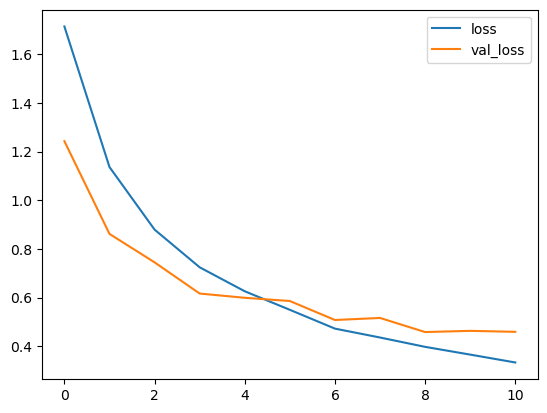

13/13 [==============================] - 4s 273ms/step - loss: 0.4860 - accuracy: 0.8525
Finished evaluation
Test set accuracy: 85%


In [24]:
model = get_initial_model()
#model = get_custom_model()
test_acc = train_test_model(model)
print(f'Test set accuracy: {test_acc:.0%}')

## Results visualization
Here a heatmap of the given model is created. It tests with the test set.

In [25]:
def print_model_test_heatmap(model):
    test_audio = []
    test_labels = []

    for audio, label in test_ds:
        test_audio.append(audio.numpy())
        test_labels.append(label.numpy())

    test_audio = np.array(test_audio)
    test_labels = np.array(test_labels)  

    y_pred = np.argmax(model.predict(test_audio), axis=1)
    y_true = test_labels

    test_acc = sum(y_pred == y_true) / len(y_true)
    #print(f'Test set accuracy: {test_acc:.0%}')
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

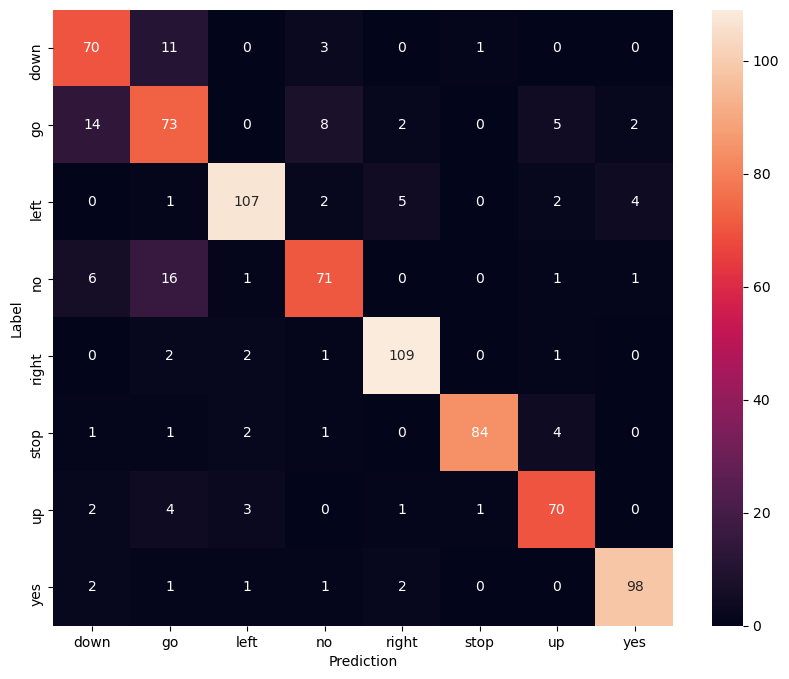

In [26]:
print_model_test_heatmap(model)